# 0. Imports

In [80]:
import sys
import os
# Adiciona o diretório raiz ao path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "..")))

# 1. Data Loading
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer

# 3. Modelos de Machine Learning
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Dropout, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adamax

from sklearn.naive_bayes import GaussianNB

from src.utils import plot_confusion_matrix


# 1. Data Loading

In [7]:
df = pd.read_csv('/home/esdras-daniel/Documentos/Python/PGM-DataAnalysis/data/not_named/df_selecionado2.csv')

df.head(3)

,Unnamed: 0,setorDestino,tipoAviso,orgaoJulgador,assuntos,documentos,classeProcesso,teorTexto_clean
0,0,AF,I,4ª VET N,10536;5952,Petição;I;Diligência;C;expedir mandado;Não ent...,1116,[TJRN] 4ª [VARA_EXECUCAO] end [NUMERO_PROCES...
1,1,AF,I,4ª VET N,10536;5952,Petição;I;Certidão;Portaria conjunta;C;Despach...,1116,[TJRN] 4ª [VARA_EXECUCAO] end [NUMERO_PROCES...
2,2,AF,I,4ª VET N,10536;5952,Petição;I;Diligência;I;Certidão de resposta ne...,1116,[TJRN] 4ª [VARA_EXECUCAO] end [NUMERO_PROCES...


## 1.1 - Limpando os dados

In [8]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [29]:
swap_dict = {'PJud': 'Outras',
             'CA': 'Outras',
             'PS': 'Outras',
             'CJ': 'Outras',
             'Chefia Patrimonial': 'Outras',
             'Procuradoria do Meio Ambiente': 'Outras',
             'AG': 'Outras',
             'CMA': 'Outras'}

df['setorDestino'].replace(swap_dict, inplace=True)

## 1.2 - Pré-processamento do texto

In [12]:
def preprocess_text(text):
    if isinstance(text, float):  # Tratar casos onde o texto é um float (NaN convertido)
      return ""
    text = text.lower()
    text = re.sub(r'[^a-zA-ZÀ-ÿ\s]', '', text) # Remove caracteres especiais, pontuação, números, etc.
    text = re.sub(r'http\S+|www\S+', '', text)   # Remove URLs
    text = re.sub(r'\s+', ' ', text).strip()    # Remove espaços extras

    # Tokenização
    words = text.split()

    # Remoção de stopwords (incluindo as específicas)
    stop_words = set(stopwords.words('portuguese'))
    stop_words.update(['procurador', 'procuradoria', 'município', 'natalrn', 'execução', 'fiscal',
                       'processo', 'dívida', 'ativa', 'conforme', 'disposto', 'intimação',
                       'prazo', 'autos', 'sobre', 'parte', 'juntada', 'documento', 'numero',
                       'art', 'lei', 'bem', 'documentos', 'sobre', 'forma', 'nº', 'autos',
                       'artigo', 'assim', 'juízo', 'juiz', 'juíza', 'despacho', 'decisão',
                       'sentença','parte', 'exequente', 'executado','executada',
                       'exequente', 'ato', 'ato_ordinatorio', 'ordinatorio','oficio',
                       'ofício', 'petição', 'sobre', 'autos', 'conforme', 'disposto',
                       'artigo', 'inciso', 'alínea', 'termos', 'ainda', 'neste',
                       'nesta', 'qualquer', 'forma', 'assim', 'sendo', 'porque',
                       'pois', 'juízo', 'juiz', 'juíza', 'parte', 'exequente', 'executado',
                       'executada', 'bem', 'documento', 'documentos', 'despacho', 'decisão',
                       'sentença', 'acórdão', 'acordão', 'agravo', 'embargos', 'apelação',
                       'recurso', 'relator', 'relatora'])
    words = [word for word in words if word not in stop_words]

    # Stemização (opcional, mas recomendado)
    stemmer = RSLPStemmer()
    words = [stemmer.stem(word) for word in words]

    return ' '.join(words)

In [13]:
df['teorTexto_clean'] = df['teorTexto_clean'].apply(preprocess_text)

In [86]:
df['teorTexto_clean'][0]

'tjrn varaexecuca end numeroprocess organizaca mn organizaca marl avelin atoordinatori conform cpc intim fazend públic quinz dia manifestars cert oj julh rozan mar silv chsecr'

In [93]:
df.head()

,setorDestino,tipoAviso,orgaoJulgador,assuntos,documentos,classeProcesso,teorTexto_clean,setor_predito_regras,score_regras,setor_predito_final,score_final
0,AF,I,4ª VET N,10536;5952,Petição;I;Diligência;C;expedir mandado;Não ent...,1116,tjrn varaexecuca end numeroprocess organizaca ...,PF,10,PF,20.0
1,AF,I,4ª VET N,10536;5952,Petição;I;Certidão;Portaria conjunta;C;Despach...,1116,tjrn varaexecuca end numeroprocess organizaca ...,PF,10,PF,20.0
2,AF,I,4ª VET N,10536;5952,Petição;I;Diligência;I;Certidão de resposta ne...,1116,tjrn varaexecuca end numeroprocess mn organiza...,PF,10,PF,20.0
3,AF,I,4ª VET N,10536;5952,Decisão;Petição de suspensão por parcelamento;...,1116,tjrn varaexecuca end numeroprocess organizaca ...,PF,10,PF,20.0
4,AF,I,4ª VET N,10536;5952,Despacho;Petição;I;Diligência;expedi ofício à ...,1116,tjrn varaexecuca end numeroprocess mn pesso co...,PF,10,PF,20.0


# 2. Implementação das Regras

In [15]:
def rule_orgao_julgador(orgao):
    score = 0
    setor = None
    if orgao in ["4ª VET N", "2ª VET N", "5ª VET N", "1ª VET N", "6ª VET N", "3ª VET N"]:
        score = 10
        setor = "PF"
    elif orgao == "3º JFP da Com NAT":
        score = 10
        setor = "DCC"
    return score, setor

def rule_classe_processo(classe):
    score = 0
    setor = None
    if classe == 1116:
        score = 10
        setor = "PF"
    elif classe == 12078:
        score = 10
        setor = "DCC"
    return score, setor

def rule_assuntos(assunto):
    score = 0
    setor = None

    if isinstance(assunto, str):  # Verifica se é uma string
      assunto_list = [int(a) for a in assunto.split(';')]  # Divide a string
    else:
      return 0, None

    if 10536 in assunto_list:
        score = 10
        setor = "PF"
    elif 9517 in assunto_list or 12078 in assunto_list:
        score = 10
        setor = "DCC"
    return score, setor

def rule_combined(row):
    score_orgao, setor_orgao = rule_orgao_julgador(row['orgaoJulgador'])
    score_classe, setor_classe = rule_classe_processo(row['classeProcesso'])
    score_assunto, setor_assunto = rule_assuntos(row['assuntos'])

    # Combinar scores (priorizando orgaoJulgador e classeProcesso)
    if setor_orgao:
        return setor_orgao, score_orgao
    elif setor_classe:
        return setor_classe, score_classe
    elif setor_assunto:
        return setor_assunto, score_assunto
    else:
        return None, 0  # Nenhuma regra se aplica

In [16]:
df['setor_predito_regras'] = None # inicializa a coluna
df['score_regras'] = 0

for index, row in df.iterrows():
    setor_predito, score = rule_combined(row)
    df.at[index, 'setor_predito_regras'] = setor_predito
    df.at[index, 'score_regras'] = score

# 3. Modelos de Machine Learning

In [53]:
# Preparar os dados para os modelos de ML
X = df['teorTexto_clean']
y = df['setorDestino']

# Dividir em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) # Usar stratify

# TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Limitar o número de features
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

## 3.1 - Multilayer Perceptron (Keras)

In [54]:
# Tokenização e Padding
tokenizer = Tokenizer(num_words=5000)  # Número máximo de palavras
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_length = max(len(seq) for seq in X_train_seq)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length)

In [55]:
# One-Hot Encoding dos rótulos (setores)
y_train_cat = pd.get_dummies(y_train).values
y_test_cat = pd.get_dummies(y_test).values
num_classes = y_train_cat.shape[1]  # Número de classes (setores)

In [56]:
# Construção do Modelo MLP Aprimorado
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_length, mask_zero=True))  # Camada de Embedding
model.add(Flatten())  # Achatar a saída do embedding
model.add(Dense(256, activation='relu'))  # Camada totalmente conectada maior
model.add(BatchNormalization())  # Normalização para estabilizar treinamento
model.add(Dropout(0.3))  # Regularização

model.add(Dense(num_classes, activation='softmax'))  # Camada de saída

model.compile(loss='categorical_crossentropy', optimizer=Adamax(learning_rate=0.002), metrics=['accuracy'])
model.summary()

# Treinamento
model.fit(X_train_pad, y_train_cat, epochs=15, batch_size=32, validation_split=0.1)

/home/esdras-daniel/Documentos/Python/PGM-DataAnalysis/.venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15


/home/esdras-daniel/Documentos/Python/PGM-DataAnalysis/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'flatten_2' (of type Flatten) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.5028 - loss: 1.3588 - val_accuracy: 0.2762 - val_loss: 11.0802
Epoch 2/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.6682 - loss: 0.9076 - val_accuracy: 0.3810 - val_loss: 4.6164
Epoch 3/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.7784 - loss: 0.6542 - val_accuracy: 0.1524 - val_loss: 3.0755
Epoch 4/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8292 - loss: 0.5712 - val_accuracy: 0.6381 - val_loss: 1.1636
Epoch 5/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.8624 - loss: 0.4449 - val_accuracy: 0.6571 - val_loss: 1.1821
Epoch 6/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8923 - loss: 0.3575 - val_accuracy: 0.6667 - val_loss: 0.9034
Epoch 7/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9030 - loss: 0.3255 - val_accuracy: 0.7333 - val_loss: 0.7721
Epoch 8/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.8836 - loss: 0.3344 - val_accuracy: 0.6857 - val_loss: 0.9045
Ep

In [74]:
# Avaliação
loss, accuracy = model.evaluate(X_test_pad, y_test_cat)
print(f'MLP - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.7706 - loss: 0.5890
MLP - Loss: 0.5749, Accuracy: 0.7756


In [58]:
# Previsões (probabilidades)
y_prob_mlp = model.predict(X_test_pad)
y_pred_mlp = np.argmax(y_prob_mlp, axis=1)  # Classes preditas

 1/15 ━━━━━━━━━━━━━━━━━━━━ 2s 204ms/step

/home/esdras-daniel/Documentos/Python/PGM-DataAnalysis/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'flatten_2' (of type Flatten) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step


## 3.2 - Naive Bayes

In [76]:
gnb = GaussianNB()
gnb.fit(X_train_tfidf.toarray(), y_train)
y_pred_gnb = gnb.predict(X_test_tfidf.toarray())
y_prob_gnb = gnb.predict_proba(X_test_tfidf.toarray()) # Probabilidades

Gaussian Naive Bayes:
              precision    recall  f1-score   support

          AF       0.96      0.72      0.82        90
         DCC       0.99      0.93      0.96        90
      Outras       0.68      0.84      0.75        90
          PA       0.71      0.69      0.70        90
          PF       0.78      0.84      0.81        90

    accuracy                           0.81       450
   macro avg       0.82      0.81      0.81       450
weighted avg       0.82      0.81      0.81       450



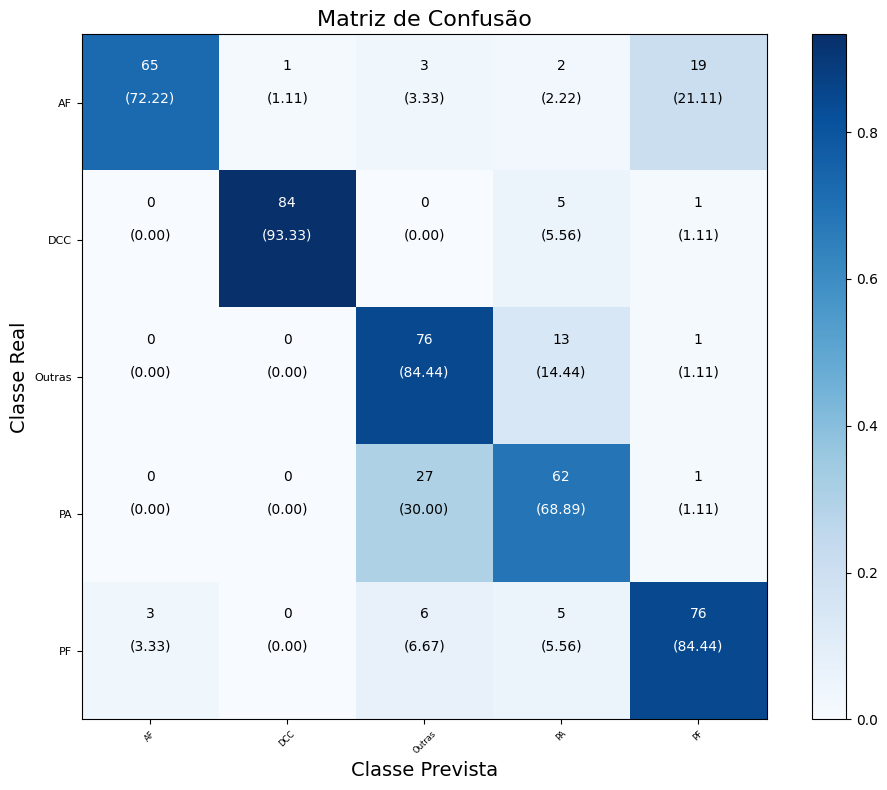

None


In [81]:
print("Gaussian Naive Bayes:")
print(classification_report(y_test, y_pred_gnb))
print(plot_confusion_matrix(y_test, y_pred_gnb, class_names=set(y_test)))

# 4. Sistema de Pontuação Descisão Final

In [82]:
def predict_setor(row):
    setor_regra, score_regra = rule_combined(row)
    if setor_regra:
        return setor_regra, score_regra * 2  # Prioridade alta para regras

    # Obter probabilidades dos modelos
    prob_gnb = gnb.predict_proba(tfidf_vectorizer.transform([row['teorTexto_clean']]).toarray())[0]
    prob_mlp = model.predict(pad_sequences(tokenizer.texts_to_sequences([row['teorTexto_clean']]), maxlen=max_length))[0]

     # Criar um dicionário de setores mapeados para índices
    setor_to_index = {setor: i for i, setor in enumerate(gnb.classes_)}

    # Usar o mapeamento para obter os índices dos setores
    index_gnb = np.argmax(prob_gnb)  # Pega o índice da maior probabilidade

    # Coletar os scores de texto
    score_texto = 0

    # Combinar scores (usando os índices)
    combined_scores = np.zeros(num_classes) # Inicializar com zeros
    combined_scores[index_gnb] += 1  # Adicionar o score do Naive Bayes (+1)
    combined_scores += prob_mlp * 3      # Adicionar o score do MLP (x3)

    # Decisão final:  usa o mapping para obter o nome do setor
    index_final = np.argmax(combined_scores) #Maior score
    setor_final = list(setor_to_index.keys())[list(setor_to_index.values()).index(index_final)]
    final_score = combined_scores[index_final]

    # Limiar de confiança
    if final_score < 4:  # Ajuste conforme necessário
      setor_final = "REVISAR MANUALMENTE"

    return setor_final, final_score

In [83]:
# Aplicar a previsão final ao DataFrame
df['setor_predito_final'] = None
df['score_final'] = 0.0

for index, row in df.iterrows():
     setor, score = predict_setor(row)
     df.at[index, 'setor_predito_final'] = setor
     df.at[index, 'score_final'] = score

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━


--- Avaliação do Sistema Híbrido ---
                     precision    recall  f1-score   support

                 AF       0.00      0.00      0.00       300
                DCC       0.51      1.00      0.68       300
             Outras       0.00      0.00      0.00       300
                 PA       0.00      0.00      0.00       300
                 PF       0.50      1.00      0.67       300
REVISAR MANUALMENTE       0.00      0.00      0.00         0

           accuracy                           0.40      1500
          macro avg       0.17      0.33      0.22      1500
       weighted avg       0.20      0.40      0.27      1500



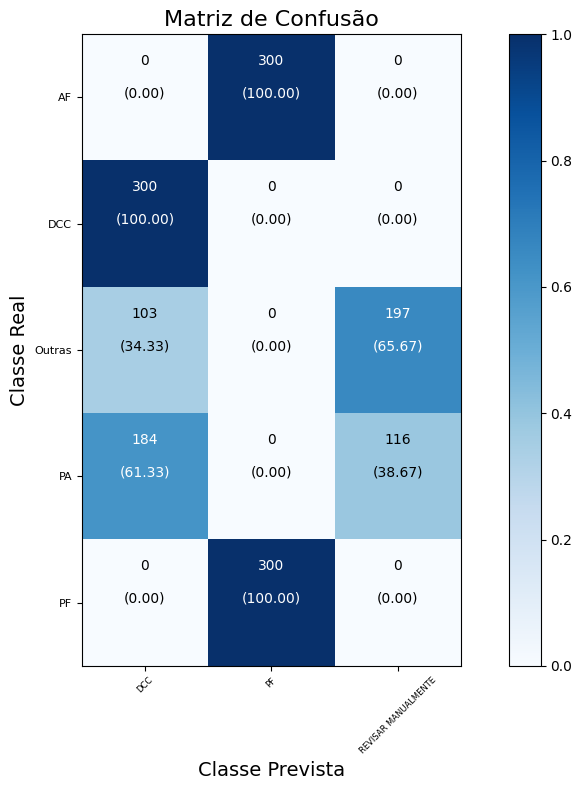

None


In [84]:
# --- 5. Avaliação do Sistema Híbrido ---
print("\n--- Avaliação do Sistema Híbrido ---")
print(classification_report(df['setorDestino'], df['setor_predito_final'], zero_division=0))
print(plot_confusion_matrix(df['setorDestino'], df['setor_predito_final'], set(df['setorDestino'])))